This notebook we will analyze customer behavior and identify customer segment by using RFM analysis.
**RFM** is the solution for identify customer segment by using historical transaction which consisted of 3 main variable.
*   Recency : Last time that users has made purchase.
*   Frequency : Total number of transaction which users made.
*   Monetary : Total or average transaction value.






In [ ]:
import pandas as pd 
import numpy as np 
import squarify
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
%matplotlib inline

In [ ]:
!pip install squarify

In [ ]:
df = pd.read_excel('Online_Retail.xlsx')

In [ ]:
df.dropna(subset= ['CustomerID'], inplace= True)

In [ ]:
## Take the void transaction out
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [ ]:
## Make Totalprice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
145093,548867,22084,PAPER CHAIN KIT EMPIRE,4,2011-04-04 14:17:00,2.95,14719.0,United Kingdom,11.80
81030,543107,21700,BIG DOUGHNUT FRIDGE MAGNETS,12,2011-02-03 12:27:00,0.85,13800.0,United Kingdom,10.20
393421,570827,21912,VINTAGE SNAKES & LADDERS,2,2011-10-12 13:14:00,3.75,15831.0,United Kingdom,7.50
284420,561871,21914,BLUE HARMONICA IN BOX,12,2011-07-31 11:46:00,1.25,13018.0,United Kingdom,15.00
226231,556784,21884,CAKES AND BOWS GIFT TAPE,1,2011-06-14 13:15:00,0.65,14461.0,United Kingdom,0.65
357406,568094,21238,RED RETROSPOT CUP,8,2011-09-23 14:43:00,0.85,15807.0,United Kingdom,6.80
455436,575621,82582,AREA PATROLLED METAL SIGN,1,2011-11-10 13:03:00,2.10,16892.0,United Kingdom,2.10
65977,541709,22499,WOODEN UNION JACK BUNTING,3,2011-01-21 11:09:00,5.95,17504.0,United Kingdom,17.85
352418,567672,23334,IVORY WICKER HEART SMALL,6,2011-09-21 15:39:00,0.63,16085.0,United Kingdom,3.78
59691,541405,84692,BOX OF 24 COCKTAIL PARASOLS,25,2011-01-17 15:17:00,0.42,12683.0,France,10.50


In [ ]:
## Choose onle needed feature
df_rfm = df[['CustomerID', 'InvoiceDate', 'InvoiceNo', 'TotalPrice']]

In [ ]:
df_rfm.sample(10)

,CustomerID,InvoiceDate,InvoiceNo,TotalPrice
487936,16369.0,2011-11-21 16:25:00,577785,12.45
214222,17589.0,2011-06-05 15:25:00,555568,2.55
338101,15529.0,2011-09-13 11:14:00,566495,4.95
530029,16015.0,2011-12-06 10:58:00,580771,1.14
266997,14198.0,2011-07-17 15:47:00,560279,15.00
30044,16033.0,2010-12-14 13:18:00,538843,4.95
422681,12626.0,2011-10-27 15:05:00,573106,16.50
37840,15640.0,2010-12-19 15:44:00,539484,1.95
143186,13124.0,2011-04-01 14:58:00,548666,34.80
291057,15241.0,2011-08-04 16:41:00,562421,2.88


In [ ]:
## Groupping by customerid and calculate RFM
rfm= df_rfm.groupby(['CustomerID']).agg({'InvoiceDate': lambda date: (df['InvoiceDate'].max() + dt.timedelta(days=1) - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [ ]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [ ]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


Let's assign RFM score to each user from rank 1-4 where 4 is the highest score.

In [ ]:
## Devide RFM score into 4 quarter
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
rfm['R'] = pd.qcut(rfm['Recency'], q= 4, labels= r_labels)
rfm['F'] = pd.qcut(rfm['Frequency'], q= 4, labels= f_labels)
rfm['M'] = pd.qcut(rfm['Monetary'], q= 4, labels= m_labels)

In [ ]:
rfm['RFM'] = rfm['R'].astype(str)+ rfm['F'].astype(str) + rfm['M'].astype(str)

In [ ]:
## Calculate the total RFM score and average RFM
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm['RFM_Avg_Score'] = rfm['RFM_Score']/3

In [ ]:
rfm

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score,RFM_Avg_Score
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6,2.000000
12347.0,2,182,4310.00,4,4,4,444,12,4.000000
12348.0,75,31,1797.24,2,2,4,224,8,2.666667
12349.0,19,73,1757.55,3,3,4,334,10,3.333333
12350.0,310,17,334.40,1,1,2,112,4,1.333333
...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3,1.000000
18281.0,181,7,80.82,1,1,1,111,3,1.000000
18282.0,8,12,178.05,4,1,1,411,6,2.000000


Let's identify customer segment by the RFM score into four group as follows :
*   **Champion** : are top class of customer who bought recently, frequent purchased and highly spender. There have a high chance that this group will reccomend your brand to other.
*   **Potential Loyalists** : are customers who bought recenty with average frequent purchased and spent a good amount.
*   **At Risk Customers** : are customer who average frequent purchase and spent a good amout but not visit your store a little bit long time. It seem like this group they are fading away.
*   **New Customers** : are customers who may rencently visit or highly spend amount but not frequent shoppers.

****Note**
To define the customers segment are depend on the business purpose and customer behavior. That not have a fixed way.




In [ ]:
def segments(df) :
  if (df['R'] == 4) and (df['F'] == 4) and (df['M'] == 4) :
    return 'Champion'
  elif (df['R'] > 2) and (df['F'] > 2) and (df['M'] > 2) :
    return 'Potential Loyalists'
  elif (df['R'] >= 1) and (df['F'] > 1) and (df['M'] > 2) :
    return 'At Risk Customers'
  else :
    return 'New Customer'

In [ ]:
rfm['Segmentation'] = rfm.apply(segments,axis=1)

The below table show average and number of customers of each RFM score. As you can see the average score of each group are different for reasonable, especially group of champion. The number of new customers and at risk customers are mostly high this may not  a good sign.

In [ ]:
rfm.groupby('Segmentation').agg({'Recency':'mean','Frequency':'mean',
                                 'Monetary':['mean','count']}).round(1)

Recency Frequency Monetary      
                       mean      mean     mean count
Segmentation                                        
At Risk Customers     102.1      76.8   1704.9   757
Champion                7.3     374.4   9319.2   447
New Customer          132.0      26.2    530.1  2286
Potential Loyalists    22.5     132.7   2645.5   848

The below graph show the size of area in each customers group. As you can see a half area are new customer and champion group are smallest area in the graph. This a sign indicate which this store must do something that 
stimulate purchase amount and returning back. **For example, new customer** group the store must be buid a good relationd ship with this group or provide the special offer to increase their visit. **At risk customer** group this group the store may back to explore the historical transaction which product thier had been bought and arrange the proper promotion for them to make a re purchase.  **Potential Loyalists** this group the store should find the solution to upsell them, such as reccomend related product or arrange a promotion for product that client never buy and probability buy. To increase their RFM score equal to the champion group.  

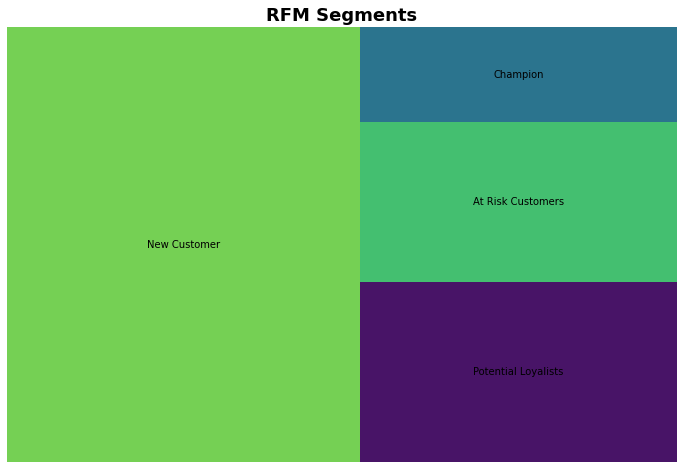

In [ ]:
fig = plt.figure(figsize=(12, 8))
squarify.plot(sizes=rfm['Segmentation'].value_counts(), 
              label=['New Customer', 'Potential Loyalists',
                     'At Risk Customers', 'Champion'])
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

**Credits**
*   https://clevertap.com/blog/rfm-analysis/?fbclid=IwAR04hiyFH7I0c0oORzcJZYcS_eGLdjS-UpLrehA1X1QkptF5NFlJgRsCAAc
*   https://www.optimove.com/resources/learning-center/rfm-segmentation

